# 16-720 HW6: Photometric Stereo

#### **For each question please refer to the handout for more details.**

Programming questions begin at **Q1**. **Remember to run all cells** and save the notebook to your local machine as a pdf for gradescope submission.

# Collaborators
**List your collaborators for all questions here**:


---

# Utils and Imports

Importing all necessary libraries.


In [45]:
import numpy as np
from matplotlib import pyplot as plt
from skimage.color import rgb2xyz
import warnings
from scipy.ndimage import gaussian_filter
from matplotlib import cm
from skimage.io import imread
from scipy.sparse import kron as spkron
from scipy.sparse import eye as speye
from scipy.sparse.linalg import lsqr as splsqr
import os
import shutil


Downloading the data

In [46]:
if os.path.exists('./content/data'):
  shutil.rmtree('./content/data')

os.mkdir('./content/data')
os.system("rm ./content/data/data.zip")



rm: ./content/data/data.zip: No such file or directory


256

In [47]:

!wget 'https://docs.google.com/uc?export=download&id=13nA1Haq6bJz0-h_7NmovvSRrRD76qiF0' -O ./content/data/data.zip
!unzip "./content/data/data.zip" -d "./content/"

--2024-12-02 15:30:26--  https://docs.google.com/uc?export=download&id=13nA1Haq6bJz0-h_7NmovvSRrRD76qiF0
Resolving docs.google.com (docs.google.com)... 142.250.31.113, 142.250.31.100, 142.250.31.102, ...
Connecting to docs.google.com (docs.google.com)|142.250.31.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=13nA1Haq6bJz0-h_7NmovvSRrRD76qiF0&export=download [following]
--2024-12-02 15:30:26--  https://drive.usercontent.google.com/download?id=13nA1Haq6bJz0-h_7NmovvSRrRD76qiF0&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.16.132
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.16.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6210854 (5.9M) [application/octet-stream]
Saving to: ‘./content/data/data.zip’

./content/data/data 100%[===================>]   5.92M  26.7MB/s    in 0.2s    

202

Utils Functions.

In [ ]:
def integrateFrankot(zx, zy, pad = 512):

    """
    Question 1 (j)

    Implement the Frankot-Chellappa algorithm for enforcing integrability
    and normal integration

    Parameters
    ----------
    zx : numpy.ndarray
        The image of derivatives of the depth along the x image dimension

    zy : tuple
        The image of derivatives of the depth along the y image dimension

    pad : float
        The size of the full FFT used for the reconstruction

    Returns
    ----------
    z: numpy.ndarray
        The image, of the same size as the derivatives, of estimated depths
        at each point

    """

    # Raise error if the shapes of the gradients don't match
    if not zx.shape == zy.shape:
        raise ValueError('Sizes of both gradients must match!')

    # Pad the array FFT with a size we specify
    h, w = 512, 512

    # Fourier transform of gradients for projection
    Zx = np.fft.fftshift(np.fft.fft2(zx, (h, w)))
    Zy = np.fft.fftshift(np.fft.fft2(zy, (h, w)))
    j = 1j

    # Frequency grid
    [wx, wy] = np.meshgrid(np.linspace(-np.pi, np.pi, w),
                           np.linspace(-np.pi, np.pi, h))
    absFreq = wx**2 + wy**2

    # Perform the actual projection
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        z = (-j*wx*Zx-j*wy*Zy)/absFreq

    # Set (undefined) mean value of the surface depth to 0
    z[0, 0] = 0.
    z = np.fft.ifftshift(z)

    # Invert the Fourier transform for the depth
    z = np.real(np.fft.ifft2(z))
    z = z[:zx.shape[0], :zx.shape[1]]

    return z


def enforceIntegrability(N, s, sig = 3):

    """
    Question 2 (e)

    Find a transform Q that makes the normals integrable and transform them
    by it

    Parameters
    ----------
    N : numpy.ndarray
        The 3 x P matrix of (possibly) non-integrable normals

    s : tuple
        Image shape

    Returns
    -------
    Nt : numpy.ndarray
        The 3 x P matrix of transformed, integrable normals
    """

    N1 = N[0, :].reshape(s)
    N2 = N[1, :].reshape(s)
    N3 = N[2, :].reshape(s)

    N1y, N1x = np.gradient(gaussian_filter(N1, sig), edge_order = 2)
    N2y, N2x = np.gradient(gaussian_filter(N2, sig), edge_order = 2)
    N3y, N3x = np.gradient(gaussian_filter(N3, sig), edge_order = 2)

    A1 = N1*N2x-N2*N1x
    A2 = N1*N3x-N3*N1x
    A3 = N2*N3x-N3*N2x
    A4 = N2*N1y-N1*N2y
    A5 = N3*N1y-N1*N3y
    A6 = N3*N2y-N2*N3y

    A = np.hstack((A1.reshape(-1, 1),
                   A2.reshape(-1, 1),
                   A3.reshape(-1, 1),
                   A4.reshape(-1, 1),
                   A5.reshape(-1, 1),
                   A6.reshape(-1, 1)))

    AtA = A.T.dot(A)
    W, V = np.linalg.eig(AtA)
    h = V[:, np.argmin(np.abs(W))]

    delta = np.asarray([[-h[2],  h[5], 1],
                        [ h[1], -h[4], 0],
                        [-h[0],  h[3], 0]])
    Nt = np.linalg.inv(delta).dot(N)

    return Nt

def plotSurface(surface, suffix=''):

    """
    Plot the depth map as a surface

    Parameters
    ----------
    surface : numpy.ndarray
        The depth map to be plotted

    suffix: str
        suffix for save file

    Returns
    -------
        None

    """
    x, y = np.meshgrid(np.arange(surface.shape[1]),
                       np.arange(surface.shape[0]))
    fig = plt.figure()
    #ax = fig.gca(projection='3d')
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(x, y, -surface, cmap = cm.coolwarm,
                           linewidth = 0, antialiased = False)
    ax.view_init(elev = 60., azim = 75.)
    plt.savefig(f'faceCalibrated{suffix}.png')
    plt.show()

def loadData(path = "../data/"):

    """
    Question 1 (c)

    Load data from the path given. The images are stored as input_n.tif
    for n = {1...7}. The source lighting directions are stored in
    sources.mat.

    Paramters
    ---------
    path: str
        Path of the data directory

    Returns
    -------
    I : numpy.ndarray
        The 7 x P matrix of vectorized images

    L : numpy.ndarray
        The 3 x 7 matrix of lighting directions

    s: tuple
        Image shape

    """
    I = None
    L = None
    s = None

    L = np.load(path + 'sources.npy').T

    im = imread(path + 'input_1.tif')
    P = im[:, :, 0].size
    s = im[:, :, 0].shape

    I = np.zeros((7, P))
    for i in range(1, 8):
        im = imread(path + 'input_' + str(i) + '.tif')
        im = rgb2xyz(im)[:, :, 1]
        I[i-1, :] = im.reshape(-1,)

    return I, L, s

def displayAlbedosNormals(albedos, normals, s):

    """
    Question 1 (e)

    From the estimated pseudonormals, display the albedo and normal maps

    Please make sure to use the `coolwarm` colormap for the albedo image
    and the `rainbow` colormap for the normals.

    Parameters
    ----------
    albedos : numpy.ndarray
        The vector of albedos

    normals : numpy.ndarray
        The 3 x P matrix of normals

    s : tuple
        Image shape

    Returns
    -------
    albedoIm : numpy.ndarray
        Albedo image of shape s

    normalIm : numpy.ndarray
        Normals reshaped as an s x 3 image

    """
    albedoIm = None
    normalIm = None

    albedoIm = albedos.reshape(s)
    normalIm = (normals.T.reshape((s[0], s[1], 3))+1)/2

    plt.figure()
    plt.imshow(albedoIm, cmap = 'gray')

    plt.figure()
    plt.imshow(normalIm, cmap = 'rainbow')

    plt.show()

    return albedoIm, normalIm

# Q1: Calibrated photometric stereo (75 points)


### Q 1 (a): Understanding n-dot-l lighting (5 points)

---

Understanding the n·l Lighting Model

The n·l lighting model is a fundamental concept in computer graphics used to simulate diffuse reflection on surfaces. It calculates the intensity of light that a surface point reflects based on the angle between the surface normal and the light source direction.

Where Does the Dot Product Come From?

The dot product between the normal vector n and the light direction vector l computes the cosine of the angle θ between these two vectors:

￼

Since we usually normalize these vectors (so that ￼), the dot product simplifies to:

￼

This cosine term is crucial because it represents how much the surface is facing the light source. A larger cosine value (closer to 1) means the surface is directly facing the light, resulting in maximum illumination. A smaller cosine value (closer to 0) means the surface is oriented away from the light(perpendicular), resulting in less illumination.

Role of Projected Area (Fig. 2b)

The concept of projected area helps explain why the cosine of the angle affects the lighting. Imagine a small patch of the surface with area dA. When light hits this patch at an angle θ, the effective area that “receives” the light is the projection of dA onto a plane perpendicular to the light direction, which is cosθ dA. This projected area determines how much light the surface patch intercepts. Therefore, the intensity of the diffuse reflection is proportional to ￼, which is directly computed by the dot product n·l

Why Does the Viewing Direction Not Matter?

In the diffuse (Lambertian) reflection model, the surface scatters light uniformly in all directions. This means that the intensity of the reflected light is the same regardless of the viewer’s position. Therefore, the viewing direction does not affect the calculation of diffuse lighting in the n·l model.


---


### Q 1 (b): Rendering the n-dot-l lighting (10 points)

In [49]:
data_dir = './content/data/'

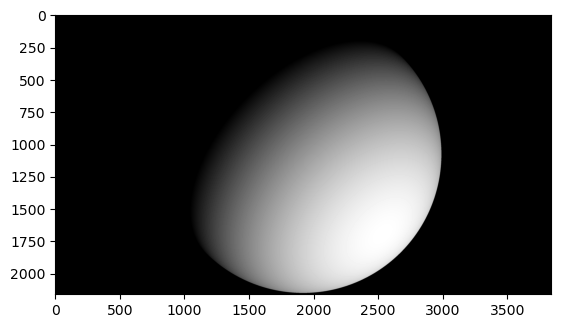

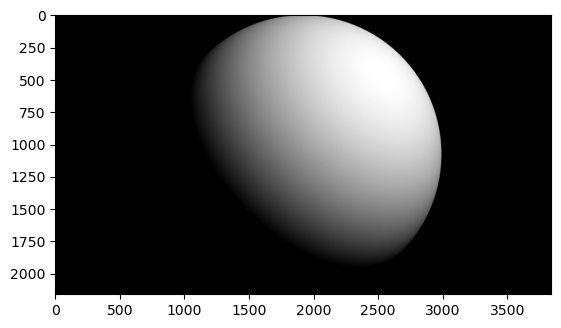

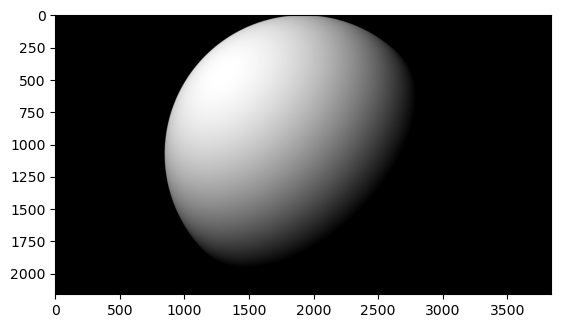

In [ ]:
def renderNDotLSphere(center, rad, light, pxSize, res):
    """
    Question 1 (b)

    Render a hemispherical bowl with a given center and radius. Assume that
    the hollow end of the bowl faces in the positive z direction, and the
    camera looks towards the hollow end in the negative z direction. The
    camera's sensor axes are aligned with the x- and y-axes.

    Parameters
    ----------
    center : numpy.ndarray
        The center of the hemispherical bowl in an array of size (3,)

    rad : float
        The radius of the bowl

    light : numpy.ndarray
        The direction of incoming light

    pxSize : float
        Pixel size

    res : numpy.ndarray
        The resolution of the camera frame

    Returns
    -------
    image : numpy.ndarray
        The rendered image of the hemispherical bowl
    """
    
    [X, Y] = np.meshgrid(np.arange(res[0]), np.arange(res[1]))
    X = (X - res[0]/2) * pxSize * 1.e-4
    Y = (Y - res[1]/2) * pxSize * 1.e-4
    Z = np.sqrt(rad**2 + 0j - X**2 - Y**2)

    # Mask out invalid points where Z is zero or imaginary
    valid = np.isreal(Z)
    Z = np.real(Z)
    Z[~valid] = 0
    X[~valid] = 0
    Y[~valid] = 0

    ### YOUR CODE HERE
    # Stack the coordinates to form position vectors
    normals = np.dstack((X, Y, Z))

    # Normalize the normals
    normals_norm = np.linalg.norm(normals, axis=2, keepdims=True)
    # Avoid division by zero
    normals_norm[normals_norm == 0] = 1
    normals = normals / normals_norm

    # Normalize the light direction
    light_dir = light / np.linalg.norm(light)

    # Compute the dot product between normals and light direction
    dot_product = np.dot(normals, light_dir)

    # Clamp the values to [0, 1]
    dot_product = np.clip(dot_product, 0, 1)

    # Initialize the image and assign the computed intensities
    image = dot_product.squeeze()
    ### END YOUR CODE

    return image
# Part 1(b)
radius = 0.75 # cm
center = np.asarray([0, 0, 0]) # cm
pxSize = 7 # um
res = (3840, 2160)

light = np.asarray([1, 1, 1])/np.sqrt(3)
image = renderNDotLSphere(center, radius, light, pxSize, res)
plt.figure()
plt.imshow(image, cmap = 'gray')
plt.imsave('1b-a.png', image, cmap = 'gray')

light = np.asarray([1, -1, 1])/np.sqrt(3)
image = renderNDotLSphere(center, radius, light, pxSize, res)
plt.figure()
plt.imshow(image, cmap = 'gray')
plt.imsave('1b-b.png', image, cmap = 'gray')

light = np.asarray([-1, -1, 1])/np.sqrt(3)
image = renderNDotLSphere(center, radius, light, pxSize, res)
plt.figure()
plt.imshow(image, cmap = 'gray')
plt.imsave('1b-c.png', image, cmap = 'gray')

I, L, s = loadData(data_dir)


### Q 1 (c): Initials (10 points)


Singular values of I:
[79.36348099 13.16260675  9.22148403  2.414729    1.61659626  1.26289066
  0.89368302]


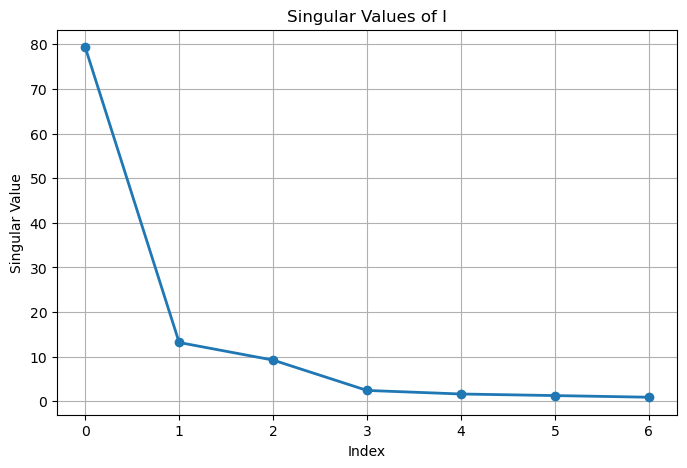

In [ ]:
### YOUR CODE HERE
# Perform Singular Value Decomposition
U, S, Vt = np.linalg.svd(I, full_matrices=False)

# Report the singular values
print("Singular values of I:")
print(S)

# Plot the singular values
plt.figure(figsize=(8, 5))
plt.plot(S, 'o-', linewidth=2)
plt.title('Singular Values of I')
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.grid(True)
plt.show()
### END YOUR CODE


---


The singular value decomposition (SVD) of the matrix reveals that the first three singular values are orders of magnitude larger than the remaining ones. This indicates that the majority of the information contained in it can be effectively captured using just three components, aligning with the theoretical expectation of a rank-3 matrix in photometric stereo. However, the smaller singular values are not exactly zero, which can be attributed to several practical factors. These include noise in the data due to sensor imperfections, deviations from the idealized model assumptions—such as surfaces not being perfectly Lambertian or lighting conditions not being ideal—and quantization errors inherent in digital image acquisition. In conclusion, while the singular values support the theoretical rank-3 requirement, the presence of small but non-zero singular values in practice highlights minor variations and inaccuracies not accounted for by the idealized model.

---

### Q 1 (d) Estimating pseudonormals (20 points)

In [ ]:
def estimatePseudonormalsCalibrated(I, L):
    """
    Question 1 (d)

    In calibrated photometric stereo, estimate pseudonormals from the
    light direction and image matrices

    Parameters
    ----------
    I : numpy.ndarray
        The 7 x P array of vectorized images

    L : numpy.ndarray
        The 3 x 7 array of lighting directions

    Returns
    -------
    B : numpy.ndarray
        The 3 x P matrix of pseudonormals
    """

    ### YOUR CODE HERE
    # Since L.T is of size (7 x 3) and I is of size (7 x P),
    # we can solve for B using least squares for all pixels at once.

    # Solve the linear system A x = y in a least-squares sense
    B, residuals, rank, s = np.linalg.lstsq(L.T, I, rcond=None)

    ### END YOUR CODE

    return B

# Part 1(e)
B = estimatePseudonormalsCalibrated(I, L)


---

To estimate the pseudonormals $ B $ in the equation $ I = L^T B $:

1. **Matrix $ A $:**
   - $ A = L^T $, the transpose of the $ 3 \times 7 $ lighting direction matrix $ L $, resulting in a $ 7 \times 3 $ matrix.
   - Each row corresponds to one light source, and columns represent the light direction components.

2. **Vector $ y $:**
   - $ y = I $, the $ 7 \times P $ matrix of pixel intensities.
   - Each column contains intensity measurements for a single pixel across 7 light sources.

3. **Solving the Linear System:**
   - The system $ I = (L^T) B $ is solved in a least-squares sense:
     $$
     B = \arg\min_B \| I - (L^T) B \|_2
     $$
   - This is computed in Python with:
   
     ```python
     B, _, _, _ = np.linalg.lstsq(L.T, I, rcond=None)
     ```

This approach estimates $ B $ by minimizing the residuals between $ I $ and $ L^T B $.

---


### Q 1 (e) Albedos and normals (10 points)

---

The observation of abnormally high albedo values in regions such as below the nose, in the ear, and below the eyes can be explained by **surface-to-surface reflections (inter-reflections)**. These reflections occur when light from the source not only reaches the specific surface but also reflects off nearby surfaces before reaching the observed surface. This issue, combined with the **assumption of a pure Lambertian reflectance model**, leads to inaccuracies in the computed albedo.


- **What Happens:**
  - In regions with complex geometry (like below the nose, ears, or around the eyes), light often bounces between surfaces before reaching the camera.
  - For example:
    - Light reflecting off the cheek can illuminate the area under the nose.
    - Light bouncing inside the ear can contribute additional intensity.

- **Impact on Measurements:**
  - These additional reflections increase the measured intensity, causing an overestimation of the albedo in these regions.


- **Limitations of the Lambertian Model:**
  - Assumes surfaces reflect light diffusely in all directions, with no dependence on viewing angle or surface geometry.
  - Does not account for specular reflections, subsurface scattering, or inter-reflections.

- **Impact in Complex Geometries:**
  - In regions like the nose, ears, or below the eyes, inter-reflections dominate, leading to artificial inflation of albedo values.


- **Concave Regions:**
  - Areas like the inner ear or under the nose create natural traps for light, where multiple reflections amplify intensity.
  
- **Self-Shadowing and Partial Occlusions:**
  - These regions may block direct light, making inter-reflections the primary source of illumination.

- **Surface Roughness:**
  - Rough microgeometry can scatter light further, deviating from the Lambertian model.


---

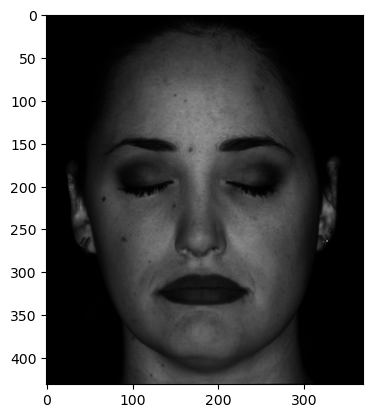

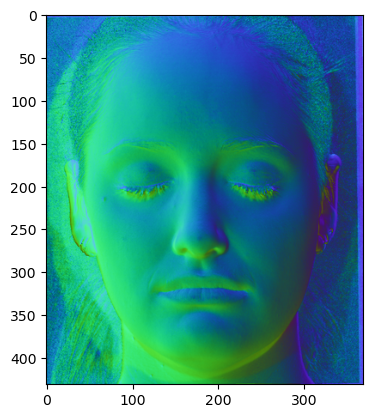

In [ ]:
def estimateAlbedosNormals(B):
    '''
    Question 1 (e)

    From the estimated pseudonormals, estimate the albedos and normals

    Parameters
    ----------
    B : numpy.ndarray
        The 3 x P matrix of estimated pseudonormals

    Returns
    -------
    albedos : numpy.ndarray
        The vector of albedos

    normals : numpy.ndarray
        The 3 x P matrix of normals
    '''

    ### YOUR CODE HERE
    # Compute the albedos as the magnitude of the pseudonormals
    albedos = np.linalg.norm(B, axis=0)

    # Avoid division by zero
    albedos_nonzero = albedos.copy()
    albedos_nonzero[albedos_nonzero == 0] = 1

    # Compute the normals by normalizing the pseudonormals
    normals = B / albedos_nonzero
    ### END YOUR CODE

    return albedos, normals


# Part 1(e)
albedos, normals = estimateAlbedosNormals(B)
albedoIm, normalIm = displayAlbedosNormals(albedos, normals, s)
plt.imsave('1f-a.png', albedoIm, cmap = 'gray')
plt.imsave('1f-b.png', normalIm, cmap = 'rainbow')


### Q 1 (f): Normals and depth (5 points)

---

The goal is to estimate the 3D shape of the face, represented as a depth map $ z = f(x, y) $, using the surface normals at each point $(x, y)$. The normal vector at a point is given by $ \mathbf{n} = (n_1, n_2, n_3) $. The components of the normal vector are directly related to the partial derivatives of the depth map.

The surface normal at a point $(x, y)$ is defined as a vector perpendicular to the tangent plane of the surface at that point. The tangent plane is described by two vectors:
1. $ \mathbf{t_x} = (1, 0, f_x) $, a tangent vector in the $x$-direction.
2. $ \mathbf{t_y} = (0, 1, f_y) $, a tangent vector in the $y$-direction.

The normal vector $ \mathbf{n} $ is the cross product of these two tangent vectors:
$$
\mathbf{n} = \mathbf{t_x} \times \mathbf{t_y}.
$$

Computing the cross product:
$$
\mathbf{t_x} \times \mathbf{t_y} =
\begin{vmatrix}
\mathbf{i} & \mathbf{j} & \mathbf{k} \\
1 & 0 & f_x \\
0 & 1 & f_y
\end{vmatrix}
= \mathbf{i}(f_x \cdot 1 - f_y \cdot 0) - \mathbf{j}(1 \cdot 1 - 0 \cdot f_x) + \mathbf{k}(1 \cdot f_y - 0 \cdot f_x).
$$

This simplifies to:
$$
\mathbf{n} = (f_x, f_y, -1).
$$

The normal vector $ \mathbf{n} $ is usually given in a normalized form, so the components satisfy:
$$
\mathbf{n} = \left( \frac{f_x}{\sqrt{f_x^2 + f_y^2 + 1}}, \frac{f_y}{\sqrt{f_x^2 + f_y^2 + 1}}, \frac{-1}{\sqrt{f_x^2 + f_y^2 + 1}} \right).
$$

Let the normalized normal vector be $ \mathbf{n} = (n_1, n_2, n_3) $. From the above equations, we can derive $ f_x $ and $ f_y $ in terms of $ n_1, n_2, n_3 $.

1. From the first component:
   $$
   n_1 = \frac{f_x}{\sqrt{f_x^2 + f_y^2 + 1}}.
   $$
   Rearranging for $ f_x $:
   $$
   f_x = -\frac{n_1}{n_3}.
   $$

2. From the second component:
   $$
   n_2 = \frac{f_y}{\sqrt{f_x^2 + f_y^2 + 1}}.
   $$
   Rearranging for $ f_y $:
   $$
   f_y = -\frac{n_2}{n_3}.
   $$

Thus:
$$
f_x = \frac{-n_1}{n_3}, \quad f_y = \frac{-n_2}{n_3}.
$$

---

####### Q 1 (g): Understanding integrability of gradients (5 points)

---

#### Understanding Integrability of Gradients

We are given a 2D discrete function $g$ defined by the matrix:
$$
g =
\begin{bmatrix}
1 & 2 & 3 & 4 \\
5 & 6 & 7 & 8 \\
9 & 10 & 11 & 12 \\
13 & 14 & 15 & 16
\end{bmatrix}.
$$

The gradients $g_x$ (horizontal) and $g_y$ (vertical) are calculated as follows:

1. **Gradient Definitions**:
   - $g_x(x_i, y_j) = g(x_{i+1}, y_j) - g(x_i, y_j)$
   - $g_y(x_i, y_j) = g(x_i, y_{j+1}) - g(x_i, y_j)$


##### Step 1: Calculate $g_x$ and $g_y$

###### $g_x$ (Horizontal Gradient)
$$
g_x =
\begin{bmatrix}
1 & 1 & 1 & 0 \\
1 & 1 & 1 & 0 \\
1 & 1 & 1 & 0 \\
1 & 1 & 1 & 0
\end{bmatrix}
$$

- Each element in $g_x$ is the difference between consecutive columns in $g$.
- The last column has $0$ since there is no subsequent column to subtract.

###### $g_y$ (Vertical Gradient)
$$
g_y =
\begin{bmatrix}
4 & 4 & 4 & 4 \\
4 & 4 & 4 & 4 \\
4 & 4 & 4 & 4 \\
0 & 0 & 0 & 0
\end{bmatrix}
$$

- Each element in $g_y$ is the difference between consecutive rows in $g$.
- The last row has $0$ since there is no subsequent row to subtract.


##### Step 2: Reconstruction of $g$

We reconstruct $g$ using the following two methods:

###### **1. First Row from $g_x$, Rest from $g_y$**
1. Start with $g(0, 0) = 1$.
2. Use $g_x$ to reconstruct the first row:
   - $g(0, 1) = g(0, 0) + g_x(0, 0) = 1 + 1 = 2$
   - $g(0, 2) = g(0, 1) + g_x(0, 1) = 2 + 1 = 3$
   - $g(0, 3) = g(0, 2) + g_x(0, 2) = 3 + 1 = 4$
   First row: $[1, 2, 3, 4]$.

3. Use $g_y$ to construct the remaining rows:
   - Second row: $[1 + 4, 2 + 4, 3 + 4, 4 + 4] = [5, 6, 7, 8]$
   - Third row: $[5 + 4, 6 + 4, 7 + 4, 8 + 4] = [9, 10, 11, 12]$
   - Fourth row: $[9 + 4, 10 + 4, 11 + 4, 12 + 4] = [13, 14, 15, 16]$

Reconstructed $g$:
$$
\begin{bmatrix}
1 & 2 & 3 & 4 \\
5 & 6 & 7 & 8 \\
9 & 10 & 11 & 12 \\
13 & 14 & 15 & 16
\end{bmatrix}
$$

###### **2. First Column from $g_y$, Rest from $g_x$**
1. Start with $g(0, 0) = 1$.
2. Use $g_y$ to reconstruct the first column:
   - $g(1, 0) = g(0, 0) + g_y(0, 0) = 1 + 4 = 5$
   - $g(2, 0) = g(1, 0) + g_y(1, 0) = 5 + 4 = 9$
   - $g(3, 0) = g(2, 0) + g_y(2, 0) = 9 + 4 = 13$
   First column: $[1, 5, 9, 13]$.

3. Use $g_x$ to construct the remaining rows:
   - Second row: $[5, 5 + 1, 6 + 1, 7 + 1] = [5, 6, 7, 8]$
   - Third row: $[9, 9 + 1, 10 + 1, 11 + 1] = [9, 10, 11, 12]$
   - Fourth row: $[13, 13 + 1, 14 + 1, 15 + 1] = [13, 14, 15, 16]$

Reconstructed $g$:
$$
\begin{bmatrix}
1 & 2 & 3 & 4 \\
5 & 6 & 7 & 8 \\
9 & 10 & 11 & 12 \\
13 & 14 & 15 & 16
\end{bmatrix}
$$


##### Step 3: Are These Reconstructions the Same?
Yes, both methods produce the same $g$. This indicates that the gradients $g_x$ and $g_y$ are **integrable**, meaning they correspond to a valid surface.

##### Step 4: Modifying Gradients to Make Them Non-Integrable
To make $g_x$ and $g_y$ non-integrable, we can introduce inconsistencies in their values such that:
$$
\frac{\partial^2 g}{\partial x \partial y} \neq \frac{\partial^2 g}{\partial y \partial x}.
$$

For example:
- Change $g_x(1, 1)$ from $1$ to $2$.
- Change $g_y(1, 1)$ from $4$ to $3$.

These changes will cause inconsistencies when reconstructing $g$, as the mixed partial derivatives will not match.

##### Why Are Gradients Estimated Non-Integrable?
Gradients estimated from real-world data may be non-integrable due to:
1. **Noise in Measurements:** Imperfect data introduces inconsistencies in $g_x$ and $g_y$.
2. **Discretization Errors:** Finite differences used to compute gradients may not perfectly capture the continuous surface.
3. **Complex Geometry:** Real-world surfaces may have discontinuities or irregularities that violate integrability.

Ensuring integrability often requires enforcing constraints during the gradient estimation or reconstruction process.

---

### Q 1 (h): Shape estimation (10 points)

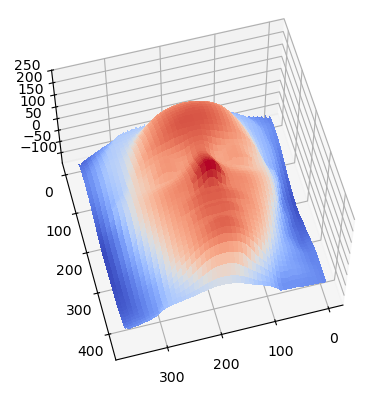

In [ ]:
def estimateShape(normals, s):
    """
    Question 1 (h)

    Integrate the estimated normals to get an estimate of the depth map
    of the surface.

    Parameters
    ----------
    normals : numpy.ndarray
        The 3 x P matrix of normals

    s : tuple
        Image shape

    Returns
    ----------
    surface: numpy.ndarray
        The image, of size s, of estimated depths at each point

    """

    ### YOUR CODE HERE
    # Reshape normals into images
    n_x = normals[0, :].reshape(s)
    n_y = normals[1, :].reshape(s)
    n_z = normals[2, :].reshape(s)

    # Avoid division by zero
    n_z_safe = n_z.copy()
    n_z_safe[n_z_safe == 0] = 1e-8  # Small epsilon to prevent division by zero

    # Compute gradients of the depth map
    z_x = -n_x / n_z_safe
    z_y = -n_y / n_z_safe

    # Integrate gradients to obtain depth map
    surface = integrateFrankot(z_x, z_y)
    ### END YOUR CODE

    return surface


# Part 1(h)
surface = estimateShape(normals, s)
plotSurface(surface)




# Q2: Uncalibrated photometric stereo (50 points)

###### Q 2 (a): Uncalibrated normal estimation (10 points)

---

###### Uncalibrated Normal Estimation

##### Problem Overview
We need to solve for the uncalibrated light directions $\hat{L}$ and pseudonormals $\hat{B}$ from the equation:
$$
I = L^T B,
$$
where neither $L$ nor $B$ is known. This is a **matrix factorization problem** with the constraint that the estimated $\hat{I}$, constructed from $\hat{L}$ and $\hat{B}$, must have a rank of 3.

This can be solved using **Singular Value Decomposition (SVD)**, a standard method for rank-constrained matrix approximation.


##### Key Insight: Rank-Constrained Matrix Approximation
For an $m \times n$ matrix $M$, the best rank-$k$ approximation is obtained as follows:
1. Perform **SVD** on $M$:
   $$
   M = U \Sigma V^T,
   $$
   where:
   - $U$ is an $m \times m$ orthogonal matrix.
   - $\Sigma$ is an $m \times n$ diagonal matrix with singular values of $M$.
   - $V^T$ is an $n \times n$ orthogonal matrix.

2. Truncate $\Sigma$ to retain only the top $k$ singular values:
   $$
   \Sigma_k = 
   \begin{bmatrix}
   \sigma_1 & 0 & \dots & 0 \\
   0 & \sigma_2 & \dots & 0 \\
   \vdots & \vdots & \ddots & \vdots \\
   0 & 0 & \dots & \sigma_k \\
   \end{bmatrix},
   $$
   where $\sigma_1 \geq \sigma_2 \geq \dots \geq \sigma_k$.

3. Reconstruct the rank-$k$ approximation:
   $$
   M_k = U \Sigma_k V^T.
   $$

This ensures that $M_k$ has the lowest reconstruction error for the given rank constraint.


##### Application to Factorization of $I$

###### Step 1: Perform SVD on $I$
Given the $m \times n$ image intensity matrix $I$, compute its SVD:
$$
I = U \Sigma V^T.
$$
- $U$ (size $m \times m$) contains the left singular vectors.
- $\Sigma$ (size $m \times n$) contains the singular values.
- $V^T$ (size $n \times n$) contains the right singular vectors.

###### Step 2: Enforce the Rank-3 Constraint
Set all singular values in $\Sigma$ except the top 3 to 0 to obtain $\Sigma_3$:
$$
\Sigma_3 = 
\begin{bmatrix}
\sigma_1 & 0 & 0 & \dots & 0 \\
0 & \sigma_2 & 0 & \dots & 0 \\
0 & 0 & \sigma_3 & \dots & 0 \\
0 & 0 & 0 & \dots & 0 \\
\end{bmatrix}.
$$

###### Step 3: Reconstruct the Rank-3 Approximation
The rank-3 approximation of $I$ is given by:
$$
\hat{I} = U \Sigma_3 V^T.
$$
This ensures that $\hat{I}$ satisfies the rank-3 constraint.

###### Step 4: Factorize into $\hat{L}$ and $\hat{B}$
The factorization of $\hat{I}$ is achieved as follows:
- Let $\hat{L}^T = \sqrt{\Sigma_3} V^T$ (size $3 \times n$).
- Let $\hat{B} = U \sqrt{\Sigma_3}$ (size $m \times 3$).

This ensures:
$$
\hat{I} = \hat{L}^T \hat{B},
$$
with the following dimensions:
- $\hat{L}$: $3 \times m$ (light directions).
- $\hat{B}$: $3 \times n$ (pseudonormals).



##### Explanation of Constraints
- **Rank Constraint**: By truncating $\Sigma$ to the top 3 singular values, $\hat{I}$ is guaranteed to have rank 3.
- **Dimensions**: The factorization ensures that $\hat{L}$ and $\hat{B}$ have appropriate dimensions for light directions and pseudonormals, respectively.

---

### Q 2 (b): Calculation and visualization (10 points)

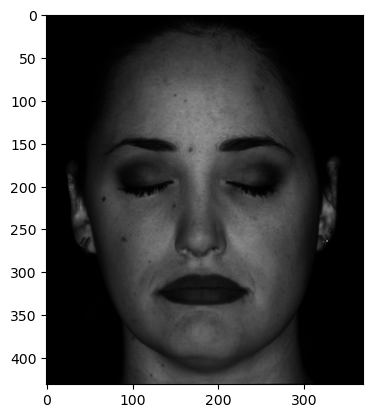

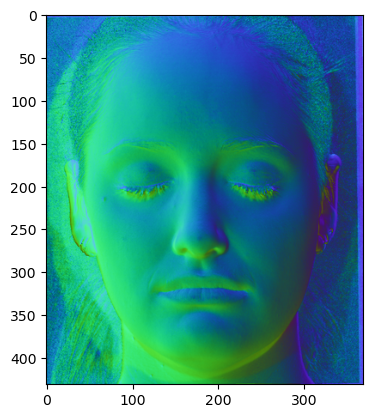

In [ ]:
def estimatePseudonormalsUncalibrated(I):
    """
    Question 2 (b)

    Estimate pseudonormals without the help of light source directions.

    Parameters
    ----------
    I : numpy.ndarray
        The N x P matrix of loaded images (N images, P pixels)

    Returns
    -------
    B : numpy.ndarray
        The 3 x P matrix of pseudonormals

    L : numpy.ndarray
        The 3 x N array of lighting directions (up to an unknown transformation)
    """

    ### YOUR CODE HERE
    # Perform SVD on the intensity matrix I
    U, S, Vt = np.linalg.svd(I, full_matrices=False)
    
    # Retain only the top 3 singular values and corresponding vectors
    U3 = U[:, :3]      # N x 3
    S3 = np.diag(S[:3])  # 3 x 3
    V3 = Vt[:3, :]     # 3 x P

    # Compute the square root of S3
    sqrt_S3 = np.sqrt(S3)

    # Estimate L' and B'
    L_est = U3 @ sqrt_S3    # N x 3
    B_est = sqrt_S3 @ V3    # 3 x P

    # Transpose L_est to match the expected output dimensions (3 x N)
    L = L_est.T
    B = B_est

    ### END YOUR CODE
    return B, L


# Part 2 (b)
I, L, s = loadData(data_dir)
B, LEst = estimatePseudonormalsUncalibrated(I)
albedos, normals = estimateAlbedosNormals(B)
albedoIm, normalIm = displayAlbedosNormals(albedos, normals, s)
plt.imsave('2b-a.png', albedoIm, cmap = 'gray')
plt.imsave('2b-b.png', normalIm, cmap = 'rainbow')


##### Q 2 (c): Comparing to ground truth lighting

---

### Comparing Estimated $\hat{L}$ to Ground Truth Lighting Directions

When comparing the estimated $\hat{L}$ (from the factorization in part (a)) to the ground truth lighting directions provided in Q1, they are likely **not the same**. This difference arises because the factorization problem $I = \hat{L}^T \hat{B}$ is under-constrained: any invertible transformation applied to both $\hat{L}$ and $\hat{B}$ would result in the same reconstructed intensity matrix $\hat{I}$, leaving $\hat{L}$ and $\hat{B}$ ambiguous up to that transformation.

#### Why Are They Different?

The singular value decomposition (SVD) decomposes the intensity matrix $I$ as:
$$
I = U \Sigma V^T,
$$
and the factorization:
$$
\hat{L}^T = \sqrt{\Sigma_3} V^T, \quad \hat{B} = U \sqrt{\Sigma_3},
$$
is not unique. The solution depends on how $\sqrt{\Sigma_3}$ is split between $\hat{L}$ and $\hat{B}$. Any invertible $3 \times 3$ matrix $T$ can be introduced such that:
$$
\hat{L}' = T \hat{L}, \quad \hat{B}' = T^{-1} \hat{B},
$$
and the product $\hat{L}'^T \hat{B}'$ still reconstructs the same intensity matrix $\hat{I}$.


#### Simple Change to the Procedure

To modify $\hat{L}$ and $\hat{B}$ while preserving the rendered images $\hat{I}$:

1. **Introduce an Invertible Transformation:**
   - Select any invertible $3 \times 3$ matrix $T$ (e.g., a rotation or scaling matrix).
   - Update $\hat{L}$ and $\hat{B}$ as:
     $$
     \hat{L}' = T \hat{L}, \quad \hat{B}' = T^{-1} \hat{B}.
     $$

2. **Effect on the Reconstruction:**
   - The product $\hat{L}'^T \hat{B}'$ becomes:
     $$
     \hat{L}'^T \hat{B}' = (T \hat{L})^T (T^{-1} \hat{B}) = \hat{L}^T \hat{B},
     $$
     which is identical to the original reconstructed matrix $\hat{I}$.

3. **Impact on Lighting Directions:**
   - The transformation $T$ changes $\hat{L}$ (the estimated lighting directions), making them differ from the ground truth, but the rendered images remain the same because the product $\hat{L}^T \hat{B}$ is unchanged.


#### Example of $T$
A simple choice for $T$ could be:
- **Scaling Matrix**: $T = \text{diag}(a, b, c)$, where $a, b, c$ are scaling factors.
- **Rotation Matrix**: $T$ is an orthogonal matrix representing a 3D rotation.
- **General Linear Transformation**: Any arbitrary invertible $3 \times 3$ matrix.


#### Summary

While the estimated $\hat{L}$ and the ground truth lighting directions are different, the rendered images remain unchanged if we modify $\hat{L}$ and $\hat{B}$ using an invertible transformation $T$. This reflects the inherent ambiguity in the factorization process, which can be resolved only with additional constraints or prior knowledge about the lighting directions.

---


### Q 2 (d): Reconstructing the shape, attempt 1 (5 points)

---

Nope

---

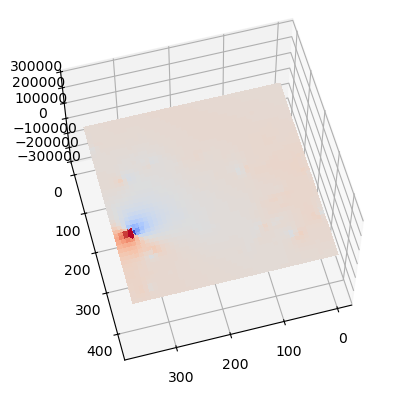

In [ ]:
# Part 2 (d)
### YOUR CODE HERE
# Load data
I, L_true, s = loadData(data_dir)

# Estimate pseudonormals and lighting directions (Uncalibrated)
B, L_est = estimatePseudonormalsUncalibrated(I)

# Estimate albedos and normals from the estimated pseudonormals
albedos, normals = estimateAlbedosNormals(B)

# Part 2(d): Reconstruct and plot the surface
# Use the normals estimated from uncalibrated photometric stereo
surface_uncalibrated = estimateShape(normals, s)

# Plot the reconstructed surface
plotSurface(surface_uncalibrated, suffix='_uncalibrated')
### END YOUR CODE

### Q 2 (e): Reconstructing the shape, attempt 2 (5 points)

---

# Reconstructing the Shape: Attempt 2

## Steps

1. **Input Pseudonormals into Enforce Integrability**:
   - The pseudonormals obtained earlier are input into the `enforceIntegrability` function. This function ensures that the pseudonormals satisfy the integrability condition, making them valid for reconstructing a consistent surface.

2. **Use Frankot-Chellappa Algorithm**:
   - The integrable pseudonormals are used with the Frankot-Chellappa algorithm to estimate the depth map (surface shape). This algorithm integrates the gradients (derived from pseudonormals) into a consistent depth map.

3. **Plot the Surface**:
   - After integration, plot the reconstructed surface as a 3D plot.

4. **Compare with Calibrated Photometric Stereo**:
   - Visually compare the reconstructed surface to the one obtained from calibrated photometric stereo.
   - Likely differences include the surface orientation or appearance, due to ambiguities in the uncalibrated process.

---

## Addressing 'Inside-Out' Surface
After integration, the surface may appear 'inside-out' due to the ambiguity in the pseudonormals' orientation. This can be corrected using the **Generalized Bas-Relief (GBR) Transform**.

### GBR Transform
The transform matrix $G$ for resolving the 'inside-out' appearance is:
$$
G = 
\begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & -1
\end{bmatrix}.
$$

1. **Apply $G$ to the Pseudonormals**:
   - Transform the pseudonormals $B$:
     $$
     B_{\text{new}} = G^{-T} B.
     $$

2. **Recompute the Normals**:
   - Update the surface normals using the transformed pseudonormals $B_{\text{new}}$.

3. **Reintegrate the Surface**:
   - Reintegrate the updated normals using the Frankot-Chellappa algorithm.

4. **Plot the Corrected Surface**:
   - Plot the surface after applying the GBR transform to ensure it has the correct orientation.

---

## Generalized Bas-Relief Ambiguity
The GBR ambiguity arises because the pseudonormals $B$ estimated through uncalibrated photometric stereo are ambiguous up to a transform of the form:
$$
G = 
\begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
\mu & \nu & \lambda
\end{bmatrix},
$$
where $\lambda > 0$, and $\mu$, $\nu$, and $\lambda$ are parameters of the transformation.

### Implications
1. **Appearance Preservation**:
   - A set of pseudonormals $B$ and their transformed version $G^{-T} B$ produce the same rendered appearance, preserving image intensities.

2. **Surface Shape Ambiguity**:
   - Different choices of $\mu$, $\nu$, and $\lambda$ lead to different reconstructed surfaces, which may still look visually similar in terms of shading.

### Why This Occurs
The GBR ambiguity reflects the fact that in uncalibrated photometric stereo, the lighting and geometry are estimated simultaneously. Without additional constraints, the solution is only unique up to the GBR transformation.


---


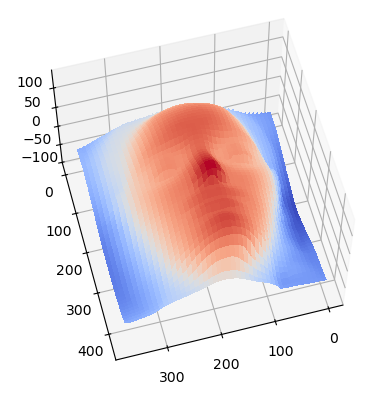

In [ ]:
# Part 2 (e)
# Your code here
### YOUR CODE HERE
I, L_true, s = loadData(data_dir)

# Estimate pseudonormals and lighting directions (Uncalibrated)
B, L_est = estimatePseudonormalsUncalibrated(I)

B_integrable = enforceIntegrability(B, s)

# Estimate albedos and normals from the estimated pseudonormals
albedos, normals = estimateAlbedosNormals(B_integrable)

# Part 2(e): Reconstruct and plot the surface
# Use the normals estimated from uncalibrated photometric stereo
surface_uncalibrated_integrable = estimateShape(normals, s)

# Plot the reconstructed surface
plotSurface(surface_uncalibrated_integrable, suffix='_uncalibrated_integrable')

### END YOUR CODE

### Q 2 (f): Why low relief? (5 points)

---

# Why Low Relief?

The bas-relief ambiguity allows surfaces reconstructed through uncalibrated photometric stereo to differ by a transformation of the form:
$$
G =
\begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
\mu & \nu & \lambda
\end{bmatrix},
$$
where $\mu$, $\nu$, and $\lambda$ control specific aspects of the transformation. These parameters introduce variations in the depth and geometry of the reconstructed surface, while preserving its shading and appearance.

---

## Varying the Parameters

### 1. **Effect of $\mu$**
- **Role**: Controls the shearing along the $x$-direction.
- **Visualization**: Increasing or decreasing $\mu$ results in a surface that appears tilted or skewed along the $x$-axis.
- **Example Surfaces**:
  - $\mu = 0$: No shearing (original surface).
  - $\mu = 2$: Strong shearing along the $x$-axis.
  - $\mu = -2$: Shearing in the opposite direction along the $x$-axis.

### 2. **Effect of $\nu$**
- **Role**: Controls the shearing along the $y$-direction.
- **Visualization**: Increasing or decreasing $\nu$ results in a surface that appears tilted or skewed along the $y$-axis.
- **Example Surfaces**:
  - $\nu = 0$: No shearing (original surface).
  - $\nu = 2$: Strong shearing along the $y$-axis.
  - $\nu = -2$: Shearing in the opposite direction along the $y$-axis.

### 3. **Effect of $\lambda$**
- **Role**: Controls the scaling of the depth (the "relief").
- **Visualization**: Increasing $\lambda$ amplifies the depth variations, creating a more pronounced surface. Decreasing $\lambda$ flattens the surface, reducing depth.
- **Example Surfaces**:
  - $\lambda = 1$: Original depth.
  - $\lambda = 0.5$: Compressed depth (low relief).
  - $\lambda = 2$: Amplified depth (high relief).

---

## Why "Low Relief"?

The term "bas-relief" originates from art, where it refers to a sculptural technique where shapes are carved into a flat surface but project only slightly. In the context of the generalized bas-relief ambiguity:
- When $\lambda < 1$, the depth is compressed, resulting in a "low-relief" surface where the variations in depth are subtle.
- The surfaces appear flatter but still preserve the shading and appearance when rendered.

This connection to the artistic concept of "bas-relief" explains why the ambiguity is named as such.

---

## Observations on the Parameters
1. $\mu$ and $\nu$ introduce skewing or tilting effects, creating geometric distortions along the $x$ and $y$ axes.
2. $\lambda$ directly scales the depth, with $\lambda > 1$ creating "high-relief" surfaces and $\lambda < 1$ creating "low-relief" surfaces.
3. These parameters control the ambiguity in surface shape while maintaining the same rendered image appearance.

---

## Colab Visualization
To illustrate these effects, create and plot at least six surfaces:
- Two surfaces with varying $\mu$ (e.g., $\mu = 2$, $\mu = -2$).
- Two surfaces with varying $\nu$ (e.g., $\nu = 2$, $\nu = -2$).
- Two surfaces with varying $\lambda$ (e.g., $\lambda = 0.5$, $\lambda = 2$).

Use these visualizations to highlight how the bas-relief ambiguity affects the surface geometry.

---

Below is the plot for mu = -2, nu = -2, lambda = 2


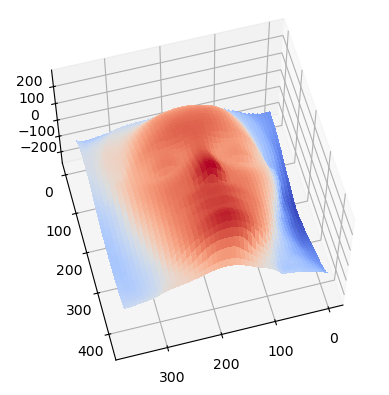

Below is the plot for mu = -2, nu = -2, lambda = 0.5


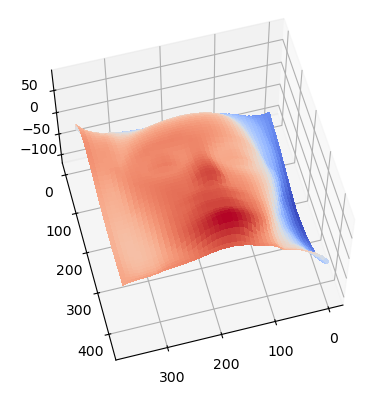

Below is the plot for mu = -2, nu = -2, lambda = 2


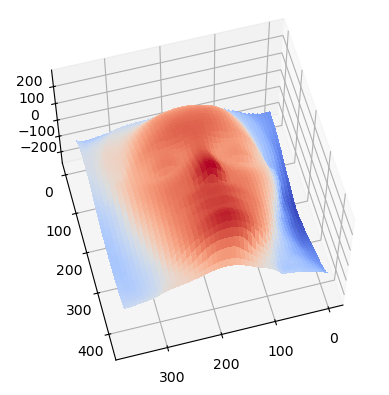

Below is the plot for mu = -2, nu = 0.5, lambda = 2


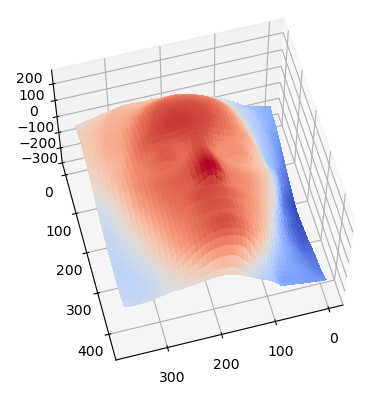

Below is the plot for mu = -2, nu = 0.5, lambda = 0.5


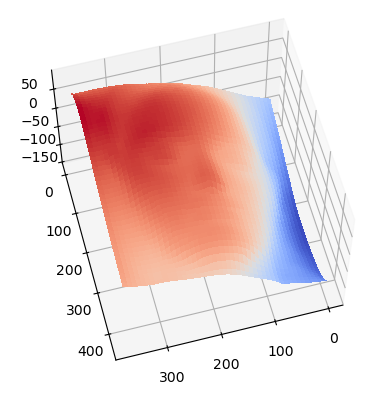

Below is the plot for mu = -2, nu = 0.5, lambda = 2


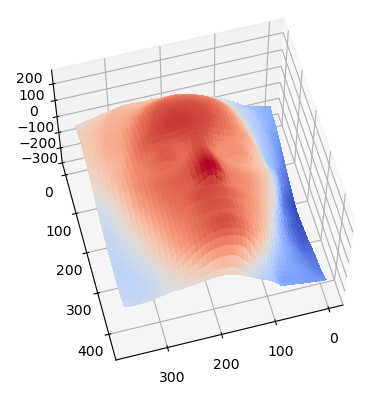

Below is the plot for mu = -2, nu = 2, lambda = 2


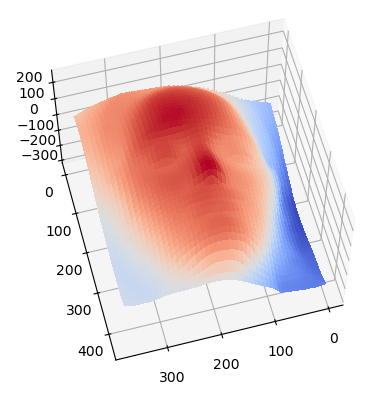

Below is the plot for mu = -2, nu = 2, lambda = 0.5


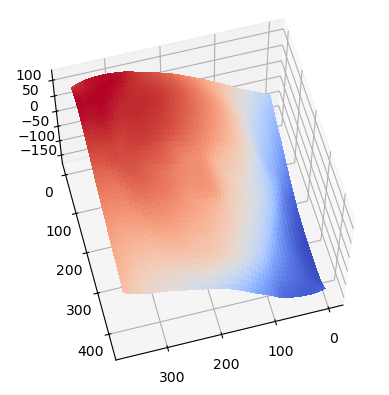

Below is the plot for mu = -2, nu = 2, lambda = 2


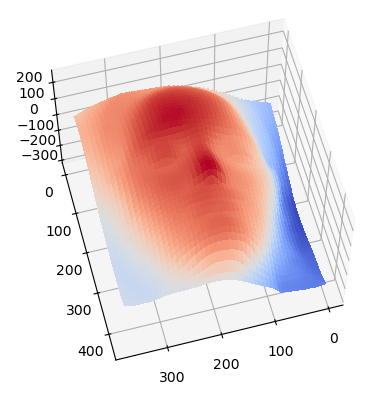

Below is the plot for mu = 0.5, nu = -2, lambda = 2


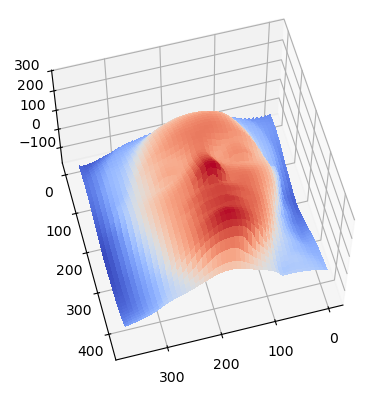

Below is the plot for mu = 0.5, nu = -2, lambda = 0.5


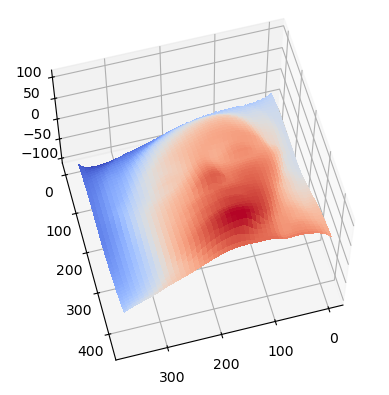

Below is the plot for mu = 0.5, nu = -2, lambda = 2


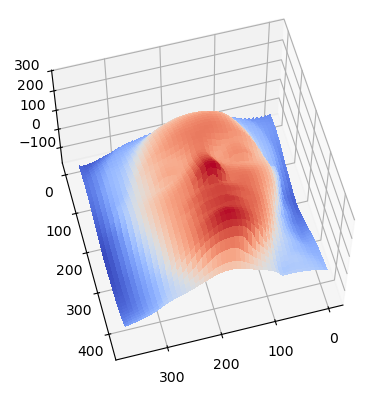

Below is the plot for mu = 0.5, nu = 0.5, lambda = 2


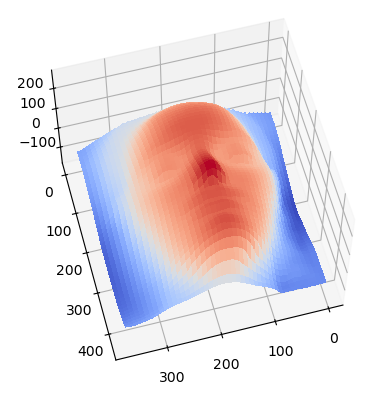

Below is the plot for mu = 0.5, nu = 0.5, lambda = 0.5


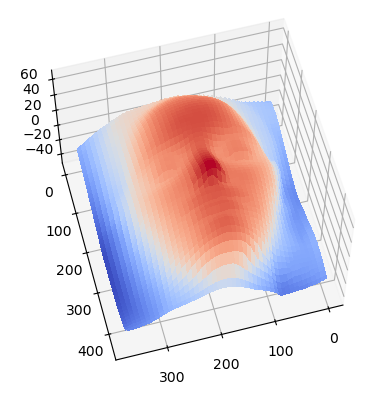

Below is the plot for mu = 0.5, nu = 0.5, lambda = 2


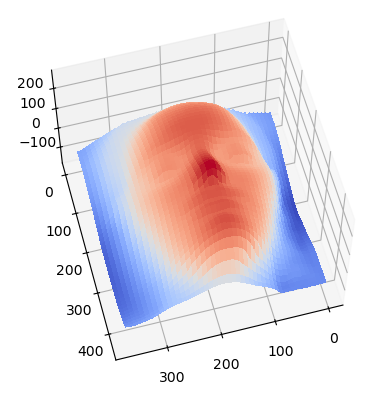

Below is the plot for mu = 0.5, nu = 2, lambda = 2


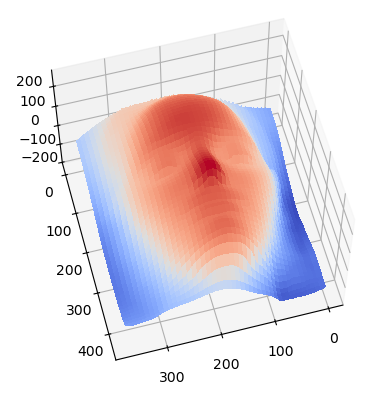

Below is the plot for mu = 0.5, nu = 2, lambda = 0.5


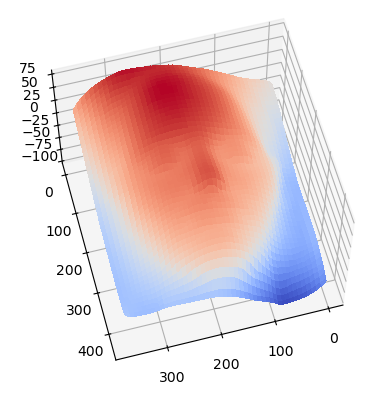

Below is the plot for mu = 0.5, nu = 2, lambda = 2


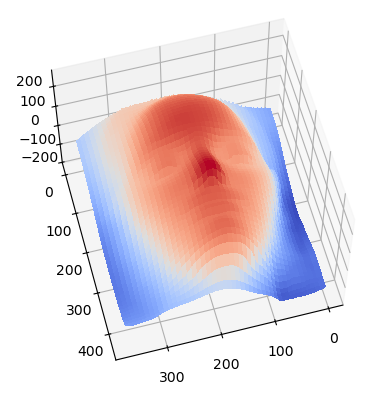

Below is the plot for mu = 2, nu = -2, lambda = 2


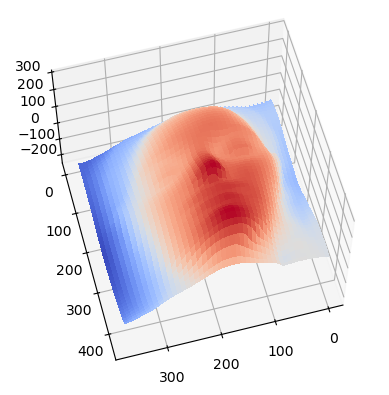

Below is the plot for mu = 2, nu = -2, lambda = 0.5


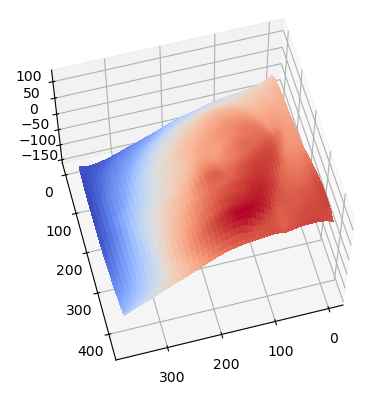

Below is the plot for mu = 2, nu = -2, lambda = 2


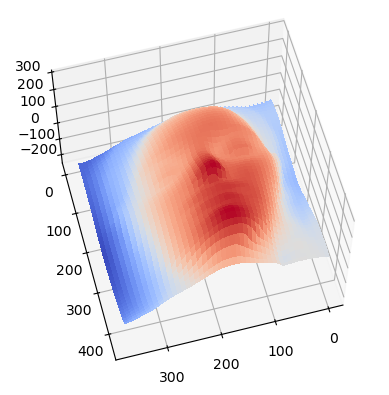

Below is the plot for mu = 2, nu = 0.5, lambda = 2


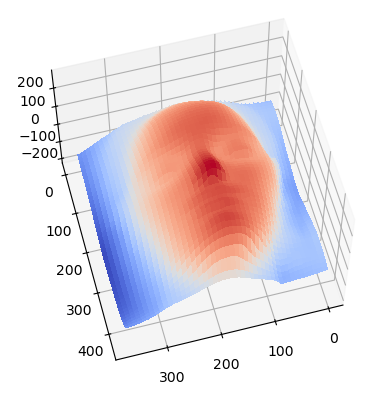

Below is the plot for mu = 2, nu = 0.5, lambda = 0.5


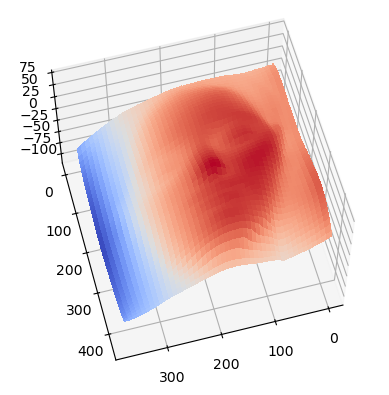

Below is the plot for mu = 2, nu = 0.5, lambda = 2


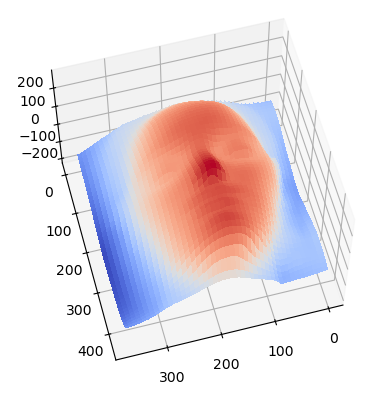

Below is the plot for mu = 2, nu = 2, lambda = 2


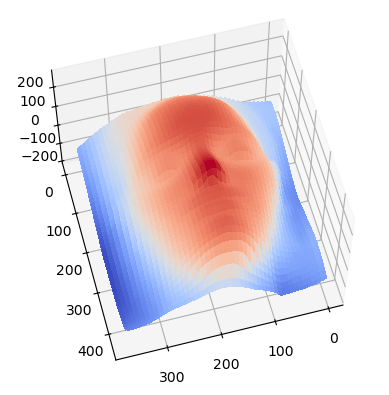

Below is the plot for mu = 2, nu = 2, lambda = 0.5


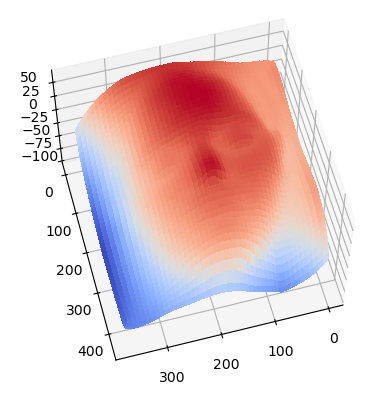

Below is the plot for mu = 2, nu = 2, lambda = 2


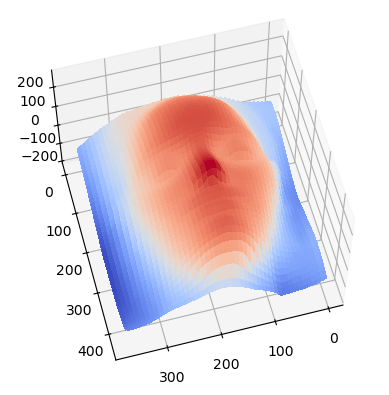

In [60]:
# Part 2(f): Exploring Bas-Relief Transformation
# Function to visualize bas-relief transformations
def plotBasRelief(B, mu, nu, lam):
    """
    Question 2 (f)

    Make a 3D plot of a bas-relief transformation with the given parameters.

    Parameters
    ----------
    B : numpy.ndarray
        The 3 x P matrix of pseudonormals

    mu : float
        bas-relief parameter

    nu : float
        bas-relief parameter

    lambda : float
        bas-relief parameter

    Returns
    -------
        None

    """
    # Bas-relief transformation matrix
    P = np.asarray([[1, 0, -mu/lam],
                    [0, 1, -nu/lam],
                    [0, 0,   1/lam]])
    # Apply transformation to pseudonormals
    Bp = P.dot(B)
    
    # Estimate shape using transformed pseudonormals
    surface = estimateShape(Bp, s)
    
    # Plot and save the surface
    plotSurface(surface, suffix=f'br_{mu}_{nu}_{lam}')

# Experimenting with Bas-Relief Transformations
# Original pseudonormals


# Varying bas-relief parameters (examples)
for mu in [-2, 0.5, 2]:
    for nu in [-2, 0.5, 2]:
        for lam in [2, 0.5, 2]:
            print("Below is the plot for mu = {}, nu = {}, lambda = {}".format(mu, nu, lam))
            plotBasRelief(B_integrable, mu, nu, lam)

### Q 2 (g): Flattest surface possible (5 points)

---

From the above experiments it is clear that the flatness of the surface is controlled by the $\lambda$ parameter. We set it to as close to 0 as possible to get the flattest possible surface.

---

##### Q 2 (h): More measurements

---

#### Short Answer
Acquiring more pictures of the face under additional lighting directions **does not resolve the generalized bas-relief (GBR) ambiguity** in uncalibrated photometric stereo. The ambiguity persists because the problem is inherently under-constrained.


#### Why Adding More Measurements Does Not Resolve GBR Ambiguity

1. **Nature of the GBR Ambiguity**:
   - The GBR ambiguity arises because the factorization problem \( I = L^T B \) is under-constrained.
   - Even with more images (increasing the size of the intensity matrix \( I \)), the ambiguity persists because any transformation of the form:
     $$
     G =
     \begin{bmatrix}
     1 & 0 & 0 \\
     0 & 1 & 0 \\
     \mu & \nu & \lambda
     \end{bmatrix},
     $$
     where \( \lambda > 0 \), can still be applied to the pseudonormals \( B \) and lighting directions \( L \), resulting in the same intensity matrix.

2. **Dependence on Shading, Not Count of Images**:
   - The shading in the images constrains the relationship between lighting directions and surface normals but does not uniquely determine them.
   - Adding more images increases the size of \( I \), but it does not introduce constraints to break the GBR ambiguity.

3. **Uncalibrated Problem**:
   - In uncalibrated photometric stereo, neither the lighting directions (\( L \)) nor the pseudonormals (\( B \)) are known. Simply adding more images does not provide the additional information needed to resolve the ambiguity.

#### When More Measurements Might Help

While adding more pictures does not resolve the GBR ambiguity, it **can improve the robustness and accuracy** of the estimated pseudonormals and lighting directions in the following ways:

1. **Noise Reduction**:
   - Additional images provide redundancy, helping to reduce the impact of noise in the measurements.

2. **Outlier Rejection**:
   - With more data, statistical methods can be used to identify and reject outliers caused by shadows, specular highlights, or other anomalies.

3. **Numerical Stability**:
   - A larger intensity matrix \( I \) improves the numerical stability of matrix factorization techniques, leading to more reliable estimates of \( L \) and \( B \).

#### Resolving the GBR Ambiguity

To resolve the GBR ambiguity, additional **prior knowledge** or constraints must be introduced:

1. **Calibrated Lighting**:
   - Knowing the lighting directions (\( L \)) eliminates the ambiguity, as the pseudonormals (\( B \)) can then be directly solved.

2. **Surface Priors**:
   - Assuming properties of the surface, such as symmetry, smoothness, or bounded curvature, can constrain the solution.

3. **Shadow or Specular Cues**:
   - Using information from shadows or specular highlights provides additional constraints to resolve the ambiguity.

4. **Non-Lambertian Models**:
   - Accounting for non-Lambertian reflectance introduces more complex constraints, reducing ambiguity.


---